<h1><center>GLM Site 121</center></h1>



### Import all the packages that we need 


In [2]:
options(warn = -1)
library(caret)
library(dplyr)
library(corrplot)
library(DMwR)
library(unbalanced)
library(ROCR)
library(pROC)
library(boot)

### Set working directory and load data

In [12]:
setwd("/Users/sunmengnan/Documents/Github2/thgfd/data/stratified")
glm_data <- read.csv("dataset_121.csv")
glm_data <- select(glm_data, -Site_Key, -Ordered_Product_Key)
head(glm_data)

Category_Level_2Accessories,Category_Level_2Bags,Category_Level_2Beauty.Boxes,Category_Level_2Body.Care,Category_Level_2Books,Category_Level_2Clothing,Category_Level_2DVD.and.Blu.Ray,Category_Level_2Footwear,Category_Level_2Fragrance,Category_Level_2Games,⋯,num_valid,count,prop,customer_status,canc_prop,ship_status,fraud_status,destination_int,priority_int,occupation_int
0,0,0,0,0,0,1,0,0,0,⋯,4,4,1,2,0,1,0,2,2,1
0,0,0,0,0,0,1,0,0,0,⋯,4,4,1,2,0,1,0,2,2,1
0,0,0,0,0,0,1,0,0,0,⋯,4,4,1,2,0,1,0,2,2,1
0,0,0,0,0,0,1,0,0,0,⋯,4,4,1,2,0,1,0,2,2,1
0,0,0,0,0,0,1,0,0,0,⋯,3,3,1,2,0,1,0,2,2,1
0,0,0,0,0,0,1,0,0,0,⋯,3,3,1,2,0,1,0,2,2,1


### Firstly, in the data cleaning process, use the Tlink to find the nearest point between fraud and non-fraud instance, which should be considered as noise and remove these data, show the sum of fraud counts, the number decreases

In [14]:
set.seed(123)
Tomek <- ubTomek(select(glm_data, -fraud_status), glm_data$fraud_status, verbose = TRUE)
glm_data <- cbind(Tomek$X, Tomek$Y)
glm_data <- rename(glm_data, fraud_status = "Tomek$Y")
head(glm_data)
table(glm_data$fraud_status)

Instances removed 294 : 0.1 % of 0 class ; 0.1 % of training ; Time needed 1.97 


Category_Level_2Accessories,Category_Level_2Bags,Category_Level_2Beauty.Boxes,Category_Level_2Body.Care,Category_Level_2Books,Category_Level_2Clothing,Category_Level_2DVD.and.Blu.Ray,Category_Level_2Footwear,Category_Level_2Fragrance,Category_Level_2Games,⋯,num_valid,count,prop,customer_status,canc_prop,ship_status,destination_int,priority_int,occupation_int,fraud_status
0,0,0,0,0,0,1,0,0,0,⋯,4,4,1,2,0,1,2,2,1,0
0,0,0,0,0,0,1,0,0,0,⋯,4,4,1,2,0,1,2,2,1,0
0,0,0,0,0,0,1,0,0,0,⋯,4,4,1,2,0,1,2,2,1,0
0,0,0,0,0,0,1,0,0,0,⋯,4,4,1,2,0,1,2,2,1,0
0,0,0,0,0,0,1,0,0,0,⋯,3,3,1,2,0,1,2,2,1,0
0,0,0,0,0,0,1,0,0,0,⋯,3,3,1,2,0,1,2,2,1,0



     0      1 
284550    797 

### Removing zero variance variables

In [15]:
glm_data <- Filter(function(x) var(x)!=0, glm_data)


glm_data <- select(glm_data, -(1:24), -Campaign_Key, -Ordered_Qty, -Cancelled_Qty, -prop,
                   -canc_prop, -count)

In [16]:
set.seed(123)
Tomek <- ubTomek(select(glm_data, -fraud_status), glm_data$fraud_status, verbose = TRUE)
glm_data <- cbind(Tomek$X, Tomek$Y)
glm_data <- rename(glm_data, fraud_status = "Tomek$Y")


Instances removed 309 : 0.11 % of 0 class ; 0.11 % of training ; Time needed 0.86 


### Omitting some conlumns which we do not need and view that top rows of the data 


In [17]:
glm_data <- select(glm_data, -Medium_Key, -pay_key_num, -Payment_Provider_Key,
                   -Payment_Method_Key, -Delivery_Option_Type_Key, -Order_Payment_Status_Key,
                   -num_valid, -Order_Sequence_No)


### Test for colinearity

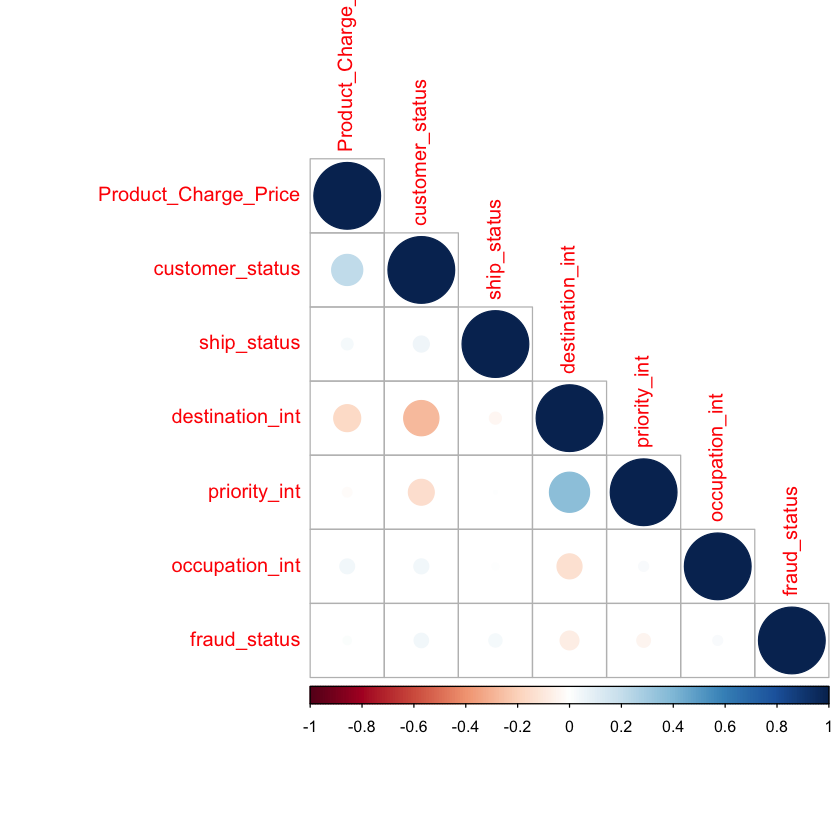

In [18]:
X <- cor(glm_data)
corrplot(X, method="circle", type = "lower")


### select the data that we want to turn into factor type, turn all the variable type into factor, keep the factor which has more than two factor levels, then combine them together again

In [20]:
temp <- select(glm_data, -Product_Charge_Price)
temp[,(1:ncol(temp))] <- lapply(temp[,(1:ncol(temp))],as.factor)
nums <- select(glm_data, Product_Charge_Price)
glm_data <- cbind(temp, nums)




new_data <- glm_data



### Create a partition to seperate the data into training part and test part

In [21]:
set.seed(123)
index <- createDataPartition(new_data$fraud_status, p = 0.6, list = FALSE)
train <- new_data[index, ]
test <- new_data[-index, ]


### Train our model using SOMTE, in each iteration, samples one minority class element , then one of its nearest neighbors. Both points are now interpolated / convex-combined, resulting in a new virtual data point for the minority class, we compare the two tables before and after SOMTE, we can see that the fraud transaction times enlarge by 10 times

In [22]:
set.seed(123)
train <- SMOTE(fraud_status ~. , train, perc.over = 1000, perc.under = 150)
table(train$fraud_status)
prop.table(table(train$fraud_status))



   0    1 
7185 5269 


        0         1 
0.5769231 0.4230769 

### Bulid a GLM model, using binomial logit link function, and also calculate the running time

In [24]:
start <- Sys.time()
model <- glm(fraud_status ~., data = train, family = binomial(link = "logit"))
end <- Sys.time()
time <- end - start
time
summary(model)

Time difference of 0.123575 secs


Call:
glm(formula = fraud_status ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7484  -0.4439  -0.4435   0.3471   2.1911  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           4.0057015  0.1495107  26.792  < 2e-16 ***
customer_status2     -3.3483839  0.1354510 -24.720  < 2e-16 ***
customer_status3     -0.9356213  0.2093455  -4.469 7.85e-06 ***
customer_status4      0.1237586  0.1686891   0.734    0.463    
ship_status2          1.5764874  0.0605855  26.021  < 2e-16 ***
destination_int2     -2.3695655  0.0715201 -33.131  < 2e-16 ***
priority_int2        -0.5548308  0.0563852  -9.840  < 2e-16 ***
occupation_int2       4.5136629  0.3305355  13.656  < 2e-16 ***
Product_Charge_Price -0.0001012  0.0004756  -0.213    0.832    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null dev

### Use our model to test our test data set, calculate the curve area value

[1] 0.7626151

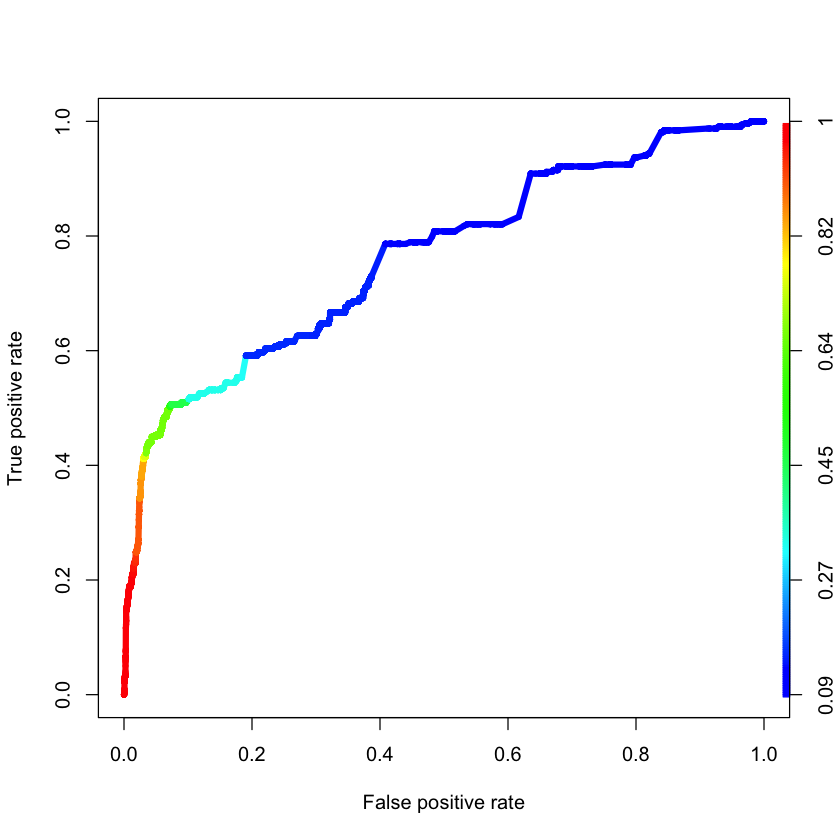

In [25]:
model_predict <- predict(model, test, type = "response")
ROC_predict <- prediction(model_predict, test$fraud_status)
ROC_performance <- performance(ROC_predict, "tpr", "fpr")
plot(ROC_performance, colorize = TRUE, text.adj = c(-0.2,1.7), lwd = 5)
area_under_curve <- performance(ROC_predict, measure = "auc")
area_under_curve@y.values[[1]]

### Set training control parameter and use this model to predict the fraud status, ouput  the confusion matrix as well

In [27]:
ctrl <- trainControl(method = "repeatedcv", number = 10, savePredictions = TRUE)
model_fit <- caret::train(fraud_status ~ customer_status + Product_Charge_Price +
                            ship_status + destination_int +
                            priority_int + occupation_int,
                   data = train, method = "glm", family = binomial(link ="logit"),
                   trControl = ctrl, tuneLength = 10)
pred <- predict(model_fit, newdata = test)
conf <- confusionMatrix(data = pred, test$fraud_status)
conf
conf$byClass

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 105347    157
         1   8349    161
                                          
               Accuracy : 0.9254          
                 95% CI : (0.9239, 0.9269)
    No Information Rate : 0.9972          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0313          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.92657         
            Specificity : 0.50629         
         Pos Pred Value : 0.99851         
         Neg Pred Value : 0.01892         
             Prevalence : 0.99721         
         Detection Rate : 0.92398         
   Detection Prevalence : 0.92536         
      Balanced Accuracy : 0.71643         
                                          
       'Positive' Class : 0               
                                          

Sensitivity          Specificity       Pos Pred Value 
          0.92656734           0.50628931           0.99851190 
      Neg Pred Value            Precision               Recall 
          0.01891892           0.99851190           0.92656734 
                  F1           Prevalence       Detection Rate 
          0.96119526           0.99721087           0.92398302 
Detection Prevalence    Balanced Accuracy 
          0.92536004           0.71642832